---
title: "3.7 Case Study: Color Compression with K-Means"
subject: Inner Products and Norms
subtitle: Clustering to compress images
short_title: "3.7 Case Study: Color Compression with K-Means"
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: K-Means, Clustering, Compression
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/02_Ch_3_Inner_Products_and_Norms/046-color_compression.ipynb)

K-means falls into the category of *unsupervised machine learning* algorithms, or algorithms which take a dataset and output patterns from that dataset. K-means, being a clustering algorithm, extracts clusters from a dataset of vectors. This is in contrast to *supervised machine learning* algorithms, which take a dataset consisting of input-output pairs, and try to learn a function mapping inputs to outputs.

In this case study, we're going to apply the [k-means algorithm](#k-means-alg) to a high-definition color picture. Our objective is to identify groups of similar colors and use these groups to compress our image. To that end, we will:

* use k-means to identify 16 "color clusters" in our image,

* visualize the distribution of colors in our image,

* use our clustering to reduce the size of our image.

# Preprocessing an Image 

Images can be represented as two-dimensional arrays of pixels (these are known as raster images), where each pixel is a vector with three components containing the pixel's RGB values, i.e. the contributions of red, blue, and green to the pixel's color. 

![close up of some rgb pixels](../figures/04-rgb.png)

Let's use the ```scikit-learn```'s ``datasets`` module to load a sample image, and print out its shape (for this to work, you'll have to have the ``pillow`` Python package installed). 


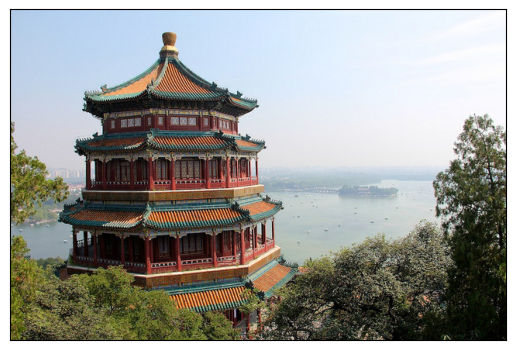

(427, 640, 3)


In [3]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)
plt.show()
print(china.shape)

The image itself is stored in a three-dimensional array of size ``(height, width, 3)``, containing red/blue/green contributions as integers from 0 to 255. The above image is 427 pixels high and 640 pixels wide.

One way we can view this set of pixels is as a cloud of $427 \times 640$ points in a three-dimensional "color space". You can represent the color space as Euclidean space $\mathbb{R}^3$, where the standard basis vectors $(1, 0, 0), (0, 1, 0), (0, 0, 1)$ represent the additive effect of one unit of red, green, or blue to a pixel's final color. 

To represent this more cleanly, let's reshape the image, which is a ``[427, 640, 3]`` array, into a dataset with dimensions ``[427 * 640, 3]``. This represents a dataset of $427 \times 640$ observations, where each observation has 3 features (the RBG values). As is standard in image processing, we will also divide all RGB components by their max value of 255, so that the resulting "normalized" image has components laying in the range $[0, 1]$:

In [4]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
print(data.shape)

(273280, 3)

## Visualizing an image as a point cloud

We can visualize these pixels in our color space, using a subset of 10000 pixels for efficiency:

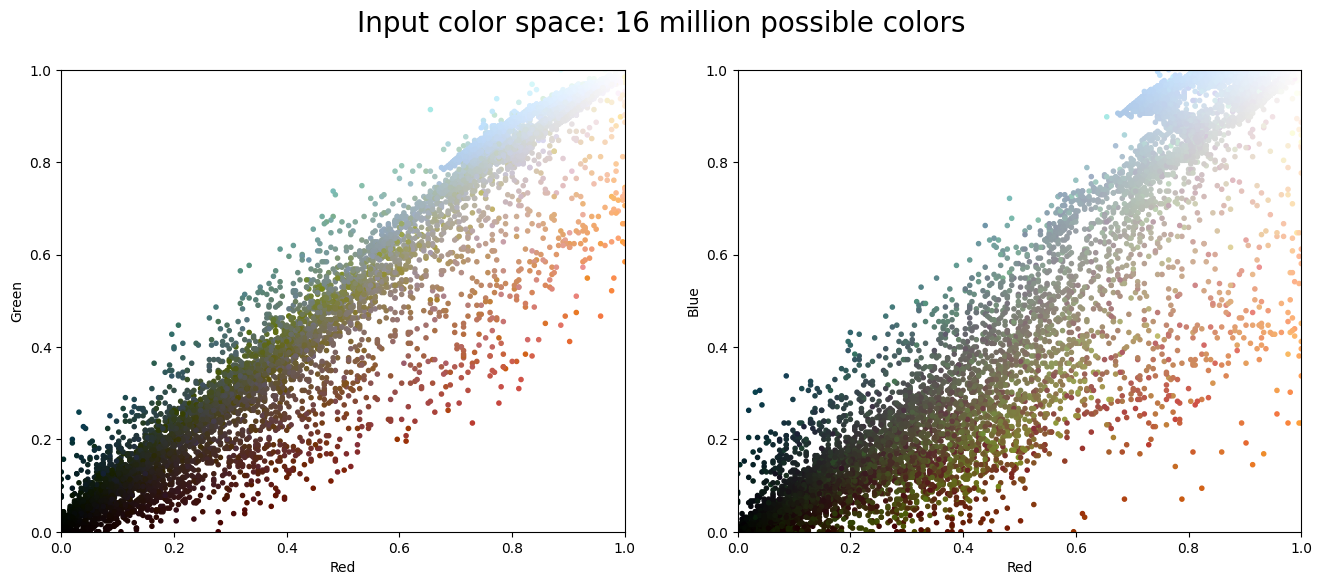

In [6]:
import numpy as np

def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

plot_pixels(data, title='Input color space: 16 million possible colors')

Here, the left plot shows the joint distribution of green and red components among pixels in our image, and the right plot shows the same for the blue and red components. After we perform dimensionality reduction using k-means, we'll use these plots to visualize the outputs of our program.

# Dimensionality Reduction via Clustering

One motivating factor for dimensionality reduction is the fact that the human eye isn't great at discerning the differences between similar colors. For example, in the below image, there are two red squares placed side by side; the left has an RGB value of ``(255, 0, 0)`` (pure red), and the right has an RGB value of ``(240, 15, 15)`` (slightly off red):

![alt text](../figures/04-reds.png)

These reds look so similar! In hexadecimal notation, these reds correspond to hex values of ``#FF0000`` and ``#F00F0F``, respectively. For those who are familiar with hex values, this essentially means that the last four bytes (out of eight) of each RGB component contribute very little overall to a human's perception of that pixel's color! This essentially means that we can *halve* the amount of data needed to represent an image with a proportionally way less significant loss to its beauty!

We can take this idea to a bigger extreme. In the following sections, we'll show that, even if we reduce the possible number of colors in the image to just 16 (essentially reducing the number of bytes to represent each pixel to just 4), we can still make out the main ideas of the image!

## Clustering the colors with minibatch k-means

Just like we did in the past few sections, we cluster the colors using the ```scikit-learn``` library. We choose $k = 16$ clusters, which corresponds to the number of colors we want in the compressed image.

Because we are dealing with a very large dataset, we will use a variation of the k-means algorithm we are familair with. The minibatch k-means algorithm, designed for large input datasets, operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm, albeit the cost of a lower quality output clustering. We also visualize the colors of the 16 cluster representatives:


(16, 3)


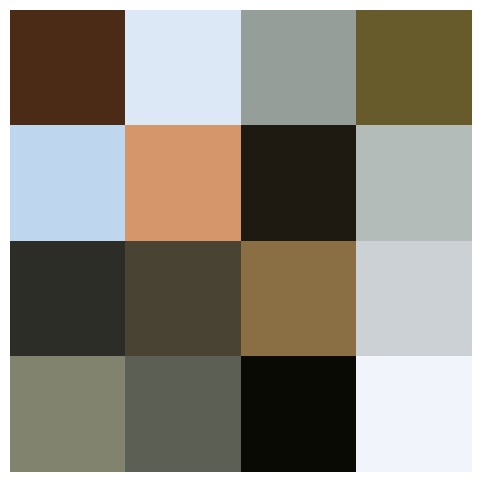

In [12]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

centers = kmeans.cluster_centers_.reshape(4, 4, 3)
plt.figure(figsize=(6, 6))
plt.imshow(centers) 
plt.axis('off')
plt.show()

And finally, the compressed image is below:

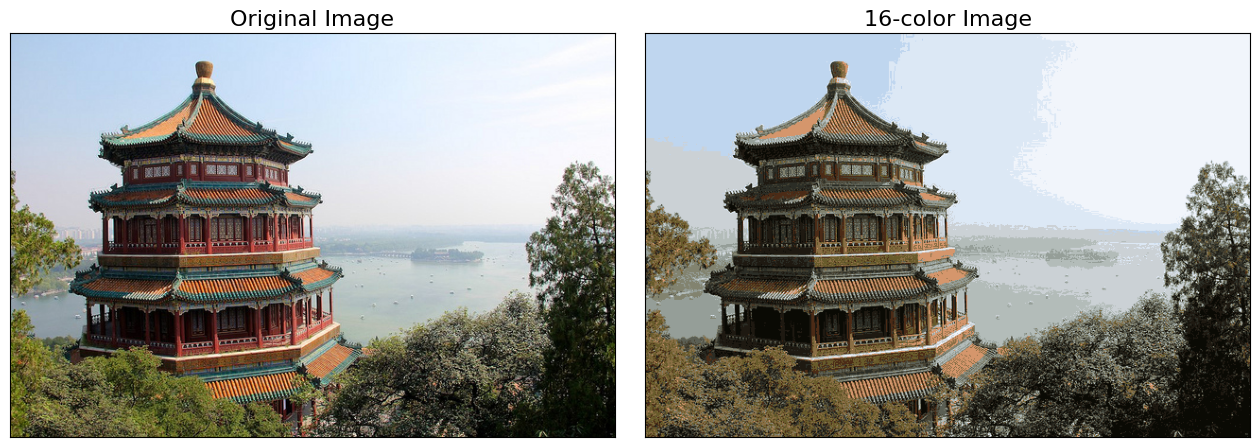

In [14]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

As you can see, we can still make out all the important features (even if the entire picture is less vibrant)!

## Visualizing the compressed image as a point cloud

Now as promised, let's revisit the plots of the components of the pixels in the compressed image to get a sense of what is happening:

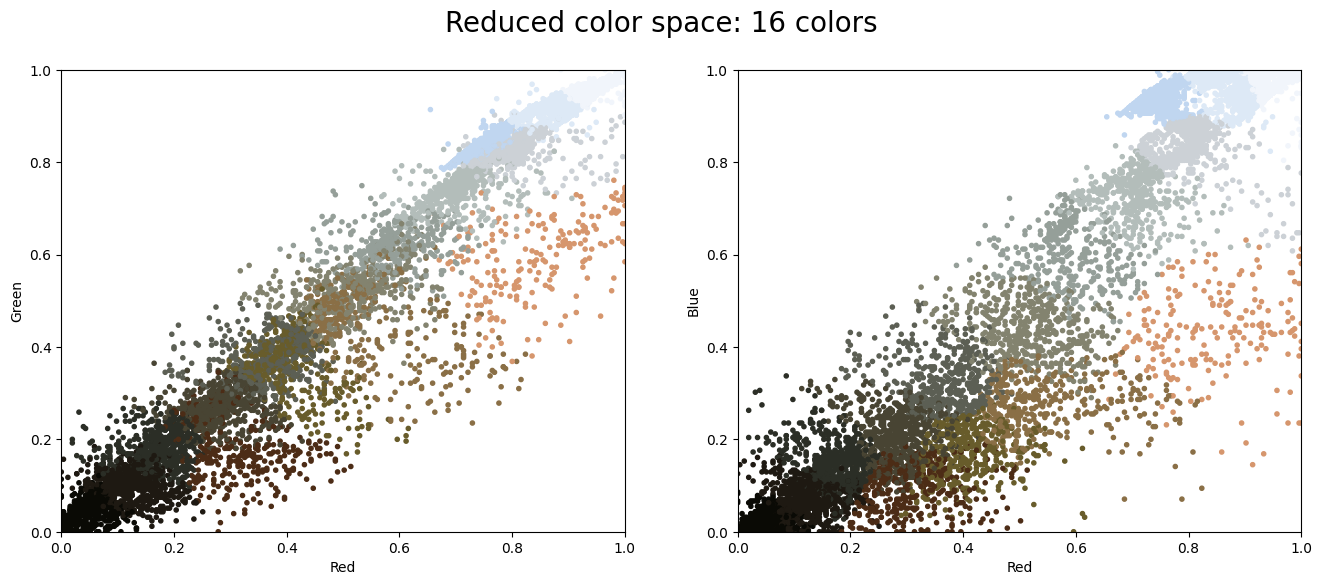

In [15]:
plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

You can see how the different clusters are separated above! Essentially, k-means tries to pick the "best" choice of 16 colors to represent the original image, where the definition of "best" in this case is induced by the [clustering objective](#clustering-objective-defn). 

This also reveals why the compressed image is less vibrant. In the original image, much of the vibrancy was due to the striking reds and greens found on the boundary of the point clouds. However, there are comparatively fewer of them compared to brown, black, and white pixels, which are located more near the interior of the point clouds. The cluster centers are thus more concentrated towards the interior of the point clouds, meaning that when we project onto the set of cluster centers, we lose the vibrant reds and greens.

While this is an interesting application of *k*-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/02_Ch_3_Inner_Products_and_Norms/046-color_compression.ipynb)